# 简介

本笔记本将介绍如何利用现有的 Stable Diffusion pipeline来生成和修改图像的基础用法，并简要了解管线中的关键组件。具体来说，我们将会涵盖：

- 使用 `StableDiffusionPipeline` 根据文本生成图像，并尝试不同的参数  
- 观察pipeline中的核心组件如何协同工作  
  - 使模型成为“潜空间扩散模型”的 VAE  
  - 处理文本提示的 tokenizer 与 text encoder  
  - 执行去噪的 UNet  
  - 不同的 scheduler，并对其进行探索  
- 利用这些组件复现采样循环  
- 通过 Img2Img 管线编辑现有图像  
- 使用修复（Inpainting）与 Depth2Img 管线进行高级编辑  


In [2]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt


from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )       



In [3]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# 文生图

让我们加载一个 Stable Diffusion pipeline 并看看它能做些什么。目前可用的 Stable Diffusion 版本有多种，这里使用`"stabilityai/stable-diffusion-2-1-base"`。如果你想探索其他版本，只需将模型 ID 替换为相应模型（例如，可以尝试 `"CompVis/stable-diffusion-v1-4"`，或从 [dreambooth concepts library](https://huggingface.co/sd-dreambooth-library) 中选择一个模型）。


In [1]:
# 对于 Windows 用户：
# 设置 HF_ENDPOINT 环境变量为 Hugging Face 镜像源（用于国内加速），
# 然后使用 huggingface-cli 下载模型到本地指定目录。
!set HF_ENDPOINT=https://hf-mirror.com&&huggingface-cli download stabilityai/stable-diffusion-2-1-base --local-dir ./stabilityai/stable-diffusion-2-1-base --repo-type model

# 对于 Linux/macOS 用户，请使用以下命令（注意使用 export 而不是 set）：
# !export HF_ENDPOINT=https://hf-mirror.com&&huggingface-cli download stabilityai/stable-diffusion-2-1-base --local-dir ./stabilityai/stable-diffusion-2-1-base --repo-type model

D:\projects\diffusion-models-class-zh\unit3\stabilityai\stable-diffusion-2-1-base



Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]Still waiting to acquire lock on stabilityai\stable-diffusion-2-1-base\.cache\huggingface\download\unet\diffusion_pytorch_model.fp16.safetensors.lock (elapsed: 10.0 seconds)
Still waiting to acquire lock on stabilityai\stable-diffusion-2-1-base\.cache\huggingface\download\unet\diffusion_pytorch_model.fp16.safetensors.lock (elapsed: 20.0 seconds)
Still waiting to acquire lock on stabilityai\stable-diffusion-2-1-base\.cache\huggingface\download\unet\diffusion_pytorch_model.fp16.safetensors.lock (elapsed: 30.1 seconds)
Still waiting to acquire lock on stabilityai\stable-diffusion-2-1-base\.cache\huggingface\download\unet\diffusion_pytorch_model.fp16.safetensors.lock (elapsed: 40.1 seconds)
Still waiting to acquire lock on stabilityai\stable-diffusion-2-1-base\.cache\huggingface\download\unet\diffusion_pytorch_model.fp16.safetensors.lock (elapsed: 50.1 seconds)
Still waiting to acquire lock on stabilityai\stable-diffusion-2-1-base\.

In [4]:
# 加载pipeline
model_id = "./stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 13.37it/s]


如果你的 GPU 显存不足，可以尝试以下方法来降低内存占用：

- **加载 FP16 版本**（并非所有系统都支持）。使用 FP16 时，在单独试验 pipeline 组件时，可能还需要将张量转换为 `torch.float16`：

  ```python
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      revision="fp16",
      torch_dtype=torch.float16
  ).to(device)
  ```

- **启用 attention slicing**。这会略微降低速度，但能显著减少显存占用：

  ```python
  pipe.enable_attention_slicing()
  ```

- **降低生成图像的分辨率**。

当 pipeline 加载完毕后，可以使用以下代码根据提示词生成图像：


d:\Users\yin-pu\miniconda3\Lib\site-packages\transformers\models\clip\modeling_clip.py:546: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 35/35 [00:04<00:00,  7.68it/s]


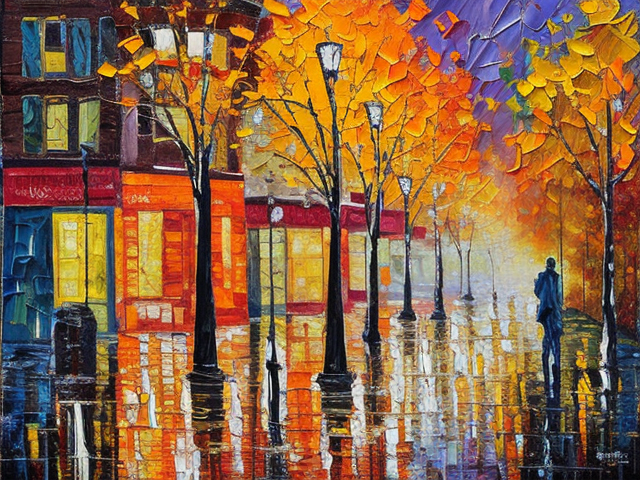

In [4]:
# 为可复现性设置随机数生成器
generator = torch.Generator(device=device).manual_seed(42)

# 运行管道，并展示部分可用参数
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape",  # 要生成的内容
    negative_prompt="Oversaturated, blurry, low quality",   # 不希望生成的内容
    height=480, width=640,      # 指定图像尺寸
    guidance_scale=8,           # 文本引导强度
    num_inference_steps=35,     # 推理步数
    generator=generator         # 固定随机种子
)

# 查看生成的图像
pipe_output.images[0]

**练习：** 试着多玩一玩上面的代码单元，用你自己的提示词并调整参数，观察它们如何影响结果。想要每次得到不同的图像，可以更换随机种子，或者直接去掉 `generator` 参数。

可调节的关键参数：

- **Width / Height**：生成图像的尺寸。为了让 VAE 正常工作，宽度和高度必须都是 **8 的倍数**（这一点我们会在后面看到原因）。  
- **num_inference_steps**：扩散步数会影响生成质量。默认值 50 效果很好，但在某些情况下，用 20 步就足以快速试验。  
- **negative_prompt**：在“无分类器引导”(classifier-free guidance)过程中使用，可帮助增加额外控制。该参数可留空，但许多用户会在此列出不希望出现的内容。  
- **guidance_scale**：决定无分类器引导（CFG）的强度。数值越高，生成图像越贴合提示词；但如果设置过高，图像可能会过度饱和、效果反而下降。  

如果需要提示词灵感，可参考 [Stable Diffusion Prompt Book](https://stability.ai/sdv2-prompt-book)。

下一单元展示了提高 `guidance_scale` 对结果的影响：


100%|██████████| 35/35 [00:03<00:00, 10.64it/s]


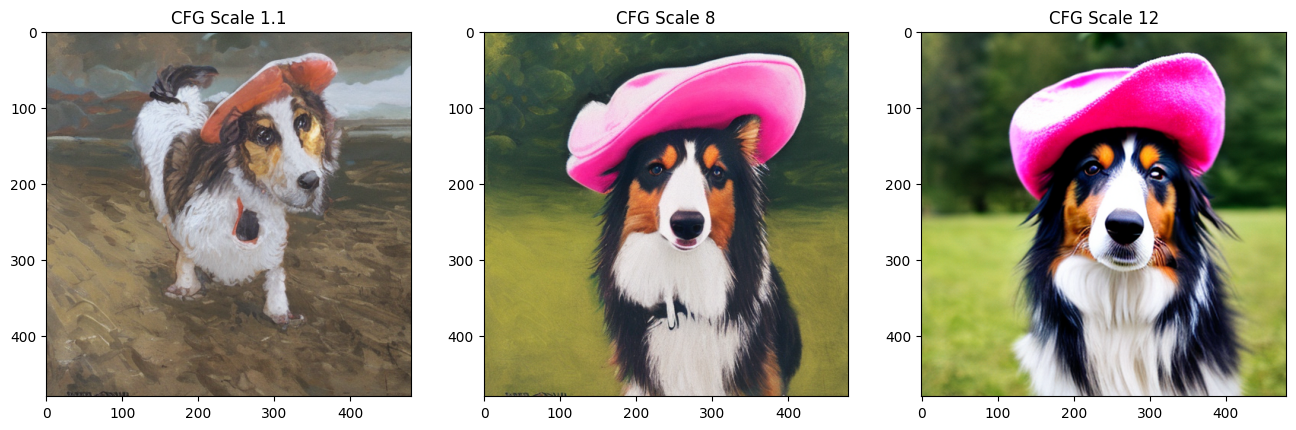

In [5]:
# 定义不同的 CFG Scale 参数列表
cfg_scales = [1.1, 8, 12]

# 设置文本提示
prompt = "A collie with a pink hat" 

# 创建一个包含 len(cfg_scales) 个子图的画布，宽度为16，高度为5
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))

# 遍历每个 CFG Scale 参数，生成并显示对应的图像
for i, ax in enumerate(axs):
    # 使用指定的 guidance_scale 和随机种子生成图像
    im = pipe(
        prompt,
        height=480,
        width=480,
        guidance_scale=cfg_scales[i],
        num_inference_steps=35,
        generator=torch.Generator(device=device).manual_seed(42)
    ).images[0]
    
    # 在子图中显示生成的图像，并设置标题为对应的 CFG Scale
    ax.imshow(im)
    ax.set_title(f'CFG Scale {cfg_scales[i]}')

试着调整上面的数值，尝试不同的 scale 和提示词组合。结果的解读因人而异，但在我看来，scale 设在 8–12 区间时，比处于该范围以下或以上的数值能产生更好的效果。


`StableDiffusionPipeline` 比我们在前面单元中探索过的 `DDPMPipeline` 要复杂一些。除了 UNet 和 scheduler 之外，pipeline 还包含若干其他组件：


In [6]:
print(list(pipe.components.keys())) # 列出包含哪些组件

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


为了更好地理解 pipeline 的运作方式，我们先分别查看各个组件的独立表现，随后再将它们组合起来，亲自复现整个 pipeline 的功能。


### VAE

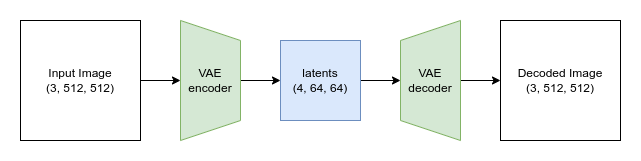

VAE（变分自编码器）是一类可以先将输入压缩成潜在（latent）表示，再把这种 **latent** 表示解码回接近原始内容的模型。在使用 Stable Diffusion 生成图像时，我们会先在 VAE 的潜空间中 **生成潜向量**（通过扩散过程），最后再 **解码** 这些潜向量，以得到可视化的图像。

下面的代码示例展示了如何将一张输入图像编码为潜向量，再使用 VAE 解码回图像：


In [9]:
import torch

# 创建一些模拟数据（随机图像，像素值范围在 -1 到 1 之间）
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# 编码到潜在空间
with torch.no_grad():
    # VAE 编码器将图像映射到潜在分布，然后取其均值并乘以缩放因子
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# 再次解码
with torch.no_grad():
    # 将潜在表示除以同样的缩放因子后送入 VAE 解码器，并取样生成图像
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)


Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


如上所示，512 × 512 像素的图像被压缩成 64 × 64 的潜空间表示（4 个通道）。这种在每个空间维度上 8 倍的压缩意味着 **width** 和 **height** 必须都是 8 的倍数。

相较于直接处理庞大的 512 px 图像，使用信息密度更高的 4 × 64 × 64 latent 表示更加高效，使得扩散模型的训练与推理速度更快、资源占用更低。虽然 VAE 的解码并非完美无损，但通常这点轻微的画质折损完全值得。

**注意：** 上述代码示例中包含了 0.18215 的缩放因子，用来匹配 Stable Diffusion 训练期间所使用的处理流程。


### Tokenizer 和 Text Encoder

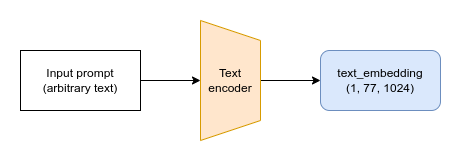

文本编码器的目标是将输入字符串（即 prompt）转换为数值表征，以便作为条件输入 UNet。首先，pipeline 的 tokenizer 会把文本转换为一系列 token。文本编码器的词汇表大约包含 5 万个 token——任何不在词汇表中的词都会被拆分成更小的子词。接着，这些 token 会被送入文本编码器本身进行处理；该编码器是一个 transformer 模型，最初作为 CLIP 的文本编码器进行训练。我们期望这个预训练的 transformer 能够学习到对扩散任务同样有用的丰富文本表征。

下面通过编码一个示例 prompt 来测试这一流程：先手动分词并送入文本编码器，再使用 pipeline 的 `encode_prompt` 方法，展示完整过程（包括将序列填充/截断到最大长度 77 个 token）。


In [12]:
# 手动对prompt进行分词和编码

# 分词
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# 转换为张量并传入设备
input_ids = torch.tensor(input_ids).to(device)

# 通过 CLIP 文本编码器进行处理
with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)


Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [13]:
# 使用pipeline的 encode_prompt 方法获取最终的文本嵌入
text_embeddings = pipe._encode_prompt(
    "A painting of a flooble",  # 输入的提示文本
    device,                     # 计算设备（如 "cuda" 或 "cpu"）
    1,                          # 批量大小
    True,                       # 是否启用文本编码器中的注意力机制
    ''                          # 额外的名称空间（通常留空）
)

# 打印文本嵌入的形状
text_embeddings.shape

d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


torch.Size([2, 77, 1024])

这些 **text embeddings**（也就是文本编码器最后一个 Transformer 块的 *hidden states*）将在下一节中作为额外参数传递给 **UNet** 的 `forward` 方法。


### The UNet

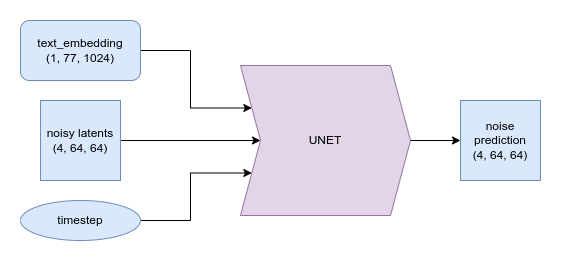

UNet 接收带噪声的输入并预测噪声，这与我们在前几单元看到的 UNet 非常相似。不过，不同之处在于，这里的输入并非图像本身，而是图像的潜空间表示（latent representation）。除了 timestep 条件之外，该 UNet 还会额外接收文本提示的嵌入（text embeddings）作为输入。下面演示它在一些 dummy data 上进行预测的过程：


In [14]:
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# 模型预测
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet 输出形状:', unet_output.shape)  # 与输入潜在向量形状相同


UNet 输出形状: torch.Size([1, 4, 64, 64])


### The Scheduler

调度器负责存储噪声时间表，并根据模型预测来更新带噪样本。默认使用 `PNDMScheduler`，但只要保持相同的配置，也可以换成其他调度器（例如 `LMSDiscreteScheduler`）。

我们可以绘制噪声时间表，观察在整个过程中的噪声水平（以 $\bar{\alpha}$ 表示）如何随时间变化：


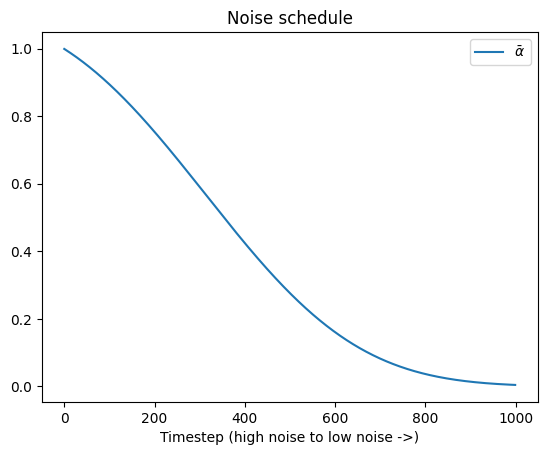

In [15]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

如果你想尝试使用不同的 scheduler，可以按如下方式替换为新的调度器：

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.34.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}



100%|██████████| 50/50 [00:04<00:00, 10.60it/s]


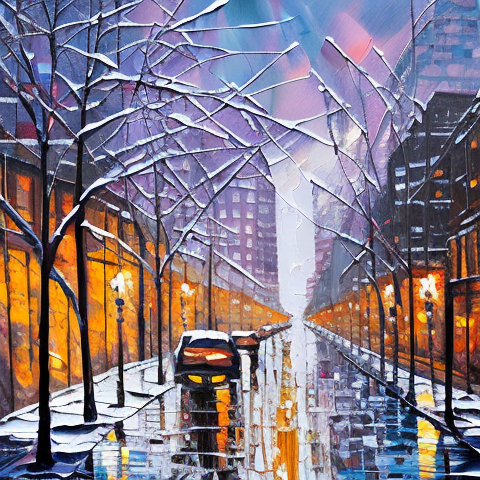

In [18]:
from diffusers import LMSDiscreteScheduler

# 使用新的调度器替换原有的 scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# 打印调度器的配置信息
print('Scheduler config:', pipe.scheduler)

# 使用新的调度器生成图像
pipe(
    prompt="Palette knife painting of an winter cityscape",
    height=480,
    width=480,
    generator=torch.Generator(device=device).manual_seed(42)
).images[0]


想深入了解如何使用不同的 schedulers，可参阅[官方文档](https://huggingface.co/docs/diffusers/using-diffusers/schedulers)。


### DIY采样循环

现在我们已了解所有组件的运行方式，可以将它们组合起来，亲手复现 pipeline 的完整功能：


d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:599: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


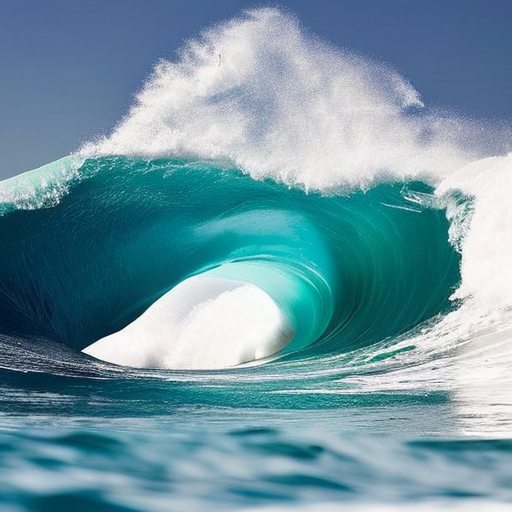

: 

In [ ]:
guidance_scale = 8  # 指导尺度（越高则更贴近提示词）
num_inference_steps = 30  # 推理步数
prompt = "Beautiful picture of a wave breaking"  # 正向提示
negative_prompt = "zoomed in, blurry, oversaturated, warped"  # 负向提示

# 对提示词进行编码
text_embeddings = pipe._encode_prompt(
    prompt,       # 正向提示
    device,       # 设备
    1,            # 生成图像数量
    True,         # 是否使用 classifier-free guidance
    negative_prompt  # 负向提示
)

# 创建随机初始噪声
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma  # 按 scheduler 的初始噪声强度缩放

# 设置调度器的时间步
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# 在每个时间步上进行采样
for i, t in enumerate(pipe.scheduler.timesteps):

    # 如果使用 classifier-free guidance，将潜在向量复制一份
    latent_model_input = torch.cat([latents] * 2)

    # 根据调度器要求对输入进行缩放
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # 使用 UNet 预测噪声残差
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=text_embeddings
        ).sample

    # 执行指导：分割为无条件和有条件两部分，然后合成
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 根据调度器计算前一步的潜在向量 x_t -> x_{t-1}
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# 将最终潜在向量解码为图像
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

# 显示生成的图像
pipe.numpy_to_pil(image)[0]


在大多数情况下，直接使用现成的 pipelines 会更简单；但拥有一个可自由“拆解”的采样循环，有助于理解并修改各组件的工作方式。如果你想查看完整代码，以及更深入地探索和修改所有不同组件，欢迎参阅 “Stable Diffusion Deep Dive” 的 [笔记本](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb) 与 [视频](https://m.youtube.com/watch?v=0_BBRNYInx8)，以获得更全面的讲解。


# 其他 Pipelines

除了直接根据提示词生成图像之外，我们还能做些什么？其实有很多！在本节中，我们将演示几种很酷的 pipeline，带你体验 Stable Diffusion 在其他任务上的应用。部分示例需要额外下载新模型；如果你时间紧迫，可以只浏览已生成的输出，而不必亲自下载并运行所有模型。


## 图生图

在前面的示例中，我们是从随机潜向量（latents）出发，经过完整的扩散采样循环，**完全从零生成**图像。但实际上，并不一定要从头开始。**Img2Img pipeline** 会先将已有图像编码成潜向量，然后在这些潜向量上加入一定量的噪声，再以此作为起点进行去噪。  
- **噪声加入量**与**去噪步数**决定了 img2img 的“强度”：  
  - 只加入少量噪声（低强度）→ 图像变化很小。  
  - 加入最大噪声并执行完整去噪（高强度）→ 得到的图像与输入几乎不相似，只保留整体结构上的些许共性。  

为了更直观地理解 img2img 过程，我们先**手动实现**这条 pipeline，以弄清楚潜向量如何编码、如何加噪以及如何进行扩散；随后再看看 `diffusers` 库提供的现成 `StableDiffusionImg2ImgPipeline` 如何让整个流程变得简单高效。

---

### 手动实现 img2img pipeline 的思路

1. **加载先前训练好的 Stable Diffusion 模型组件**（VAE、UNet、scheduler 等）。  
2. **将输入图像编码为潜向量**：  
   ```python
   latents = vae.encode(image).latent_dist.sample() * vae.config.scaling_factor


d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\models\attention_processor.py:3317: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


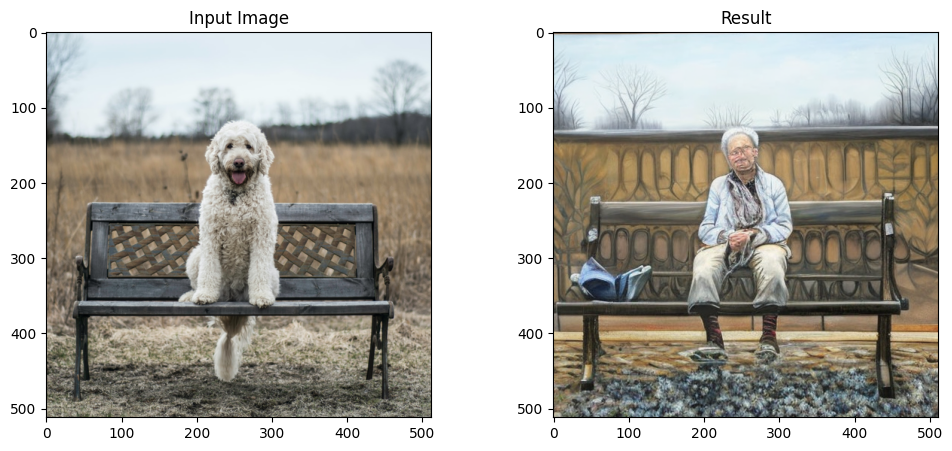

In [5]:
import numpy as np

img_path = "imgs/overture-creations-5sI6fQgYIuo.png"
mask_path = "imgs/overture-creations-5sI6fQgYIuo_mask.png"

# 设置图像尺寸
img_height = 512
img_width = 512

# 读取原始图并转换为 RGB，再调整到指定大小
init_image = (
    Image.open(img_path)        # 打开本地原始图片
    .convert("RGB")             # 转换为 RGB 模式
    .resize((img_height, img_width))  # 调整到 512×512
)


# 将 PIL 图像转换为 tensor，并从 HWC 转为 CHW，归一化到 [0,1]
init_image_tensor = torch.from_numpy(
    np.array(init_image).transpose(2, 0, 1)
).float() / 255.0                                   # 0~255 => 0~1

# 将 [0,1] 归一化映射到 [-1,1]
init_image_tensor = 2.0 * init_image_tensor - 1.0  # 0~1 => -1~1
init_image_tensor = init_image_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    # 使用 VAE 编码器将图像编码到潜在空间，并按配置缩放
    init_image_latents = (
        pipe.vae.encode(init_image_tensor)
        .latent_dist.sample()
        * pipe.vae.config.scaling_factor
    )

# 设置控制强度及采样步数
guidance_scale = 7.5   # 文本引导权重
num_inference_steps = 30  # 采样步数
strength = 0.6           # 图像保留强度
prompt = "An oil painting of a man on a bench"  # 文本提示

# 编码文本提示
text_embeddings = pipe._encode_prompt(
    prompt, device, 1, True, ''
)

# 准备调度器的时间步
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# 计算从初始图像到纯噪声所需的时间步数量
init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = pipe.scheduler.timesteps[t_start:]

# 第一个时间步用于向潜在表示添加噪声
latent_timestep = timesteps[:1]

# 生成与潜在表示相同形状的随机噪声
noise = torch.randn(
    (1, 4, 64, 64),
    device=device,
    generator=torch.Generator(device=device).manual_seed(42)
)

# 根据初始时间步添加噪声
latents = pipe.scheduler.add_noise(
    init_image_latents, noise, latent_timestep
)

# 逐步去噪过程
for i, t in enumerate(timesteps):
    # 如果使用 classifier-free guidance，需要复制潜在表示
    latent_model_input = torch.cat([latents] * 2)

    # 根据调度器要求对输入进行缩放
    latent_model_input = pipe.scheduler.scale_model_input(
        latent_model_input, t
    )

    # 使用 UNet 预测噪声残差
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t,
            encoder_hidden_states=text_embeddings
        ).sample

    # 分离无条件和有条件预测，并应用引导
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )

    # 根据调度器更新潜在表示
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# 将潜在表示解码回图像空间
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    result_image = pipe.vae.decode(latents_norm).sample

# 后处理：从 [-1,1] 映射回 [0,1]，再转为 uint8
result_image = (result_image / 2 + 0.5).clamp(0, 1).squeeze()
result_image = (result_image.permute(1, 2, 0) * 255).to(
    torch.uint8
).cpu().numpy()
result_image = Image.fromarray(result_image)

# 可视化输入图和生成结果
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title('Input Image')
axs[1].imshow(result_image)
axs[1].set_title('Result')
plt.show()

现在我们已经手动实现了 img2img 过程，接下来看看如何借助 diffusers 提供的 `StableDiffusionImg2ImgPipeline` 更高效地达成相同的效果。

该 pipeline 无需特殊模型，只要使用与前面 text-to-image 示例相同的模型 ID，就不需要下载任何新的文件。


100%|██████████| 30/30 [00:03<00:00,  9.82it/s]


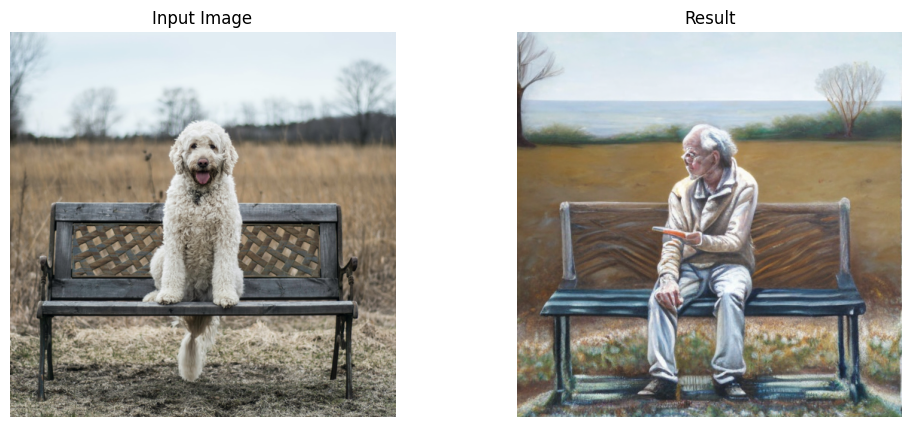

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
import matplotlib.pyplot as plt

model_id = "stabilityai/stable-diffusion-2-1-base"

# 加载 Img2Img 管道
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

# 应用 Img2Img，传入提示词和初始图像，以及强度参数
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",  # 文本提示
    image=init_image,                             # 初始输入图像
    strength=0.6,                                 # 强度：0 表示无变化，1.0 表示最大变化
).images[0]

# 可视化初始图像与结果图像
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title('Input Image')     # 输入图像标题
axs[0].axis('off')                   # 隐藏坐标轴
axs[1].imshow(result_image)
axs[1].set_title('Result')          # 结果图像标题
axs[1].axis('off')                   # 隐藏坐标轴
plt.show()


## In-Painting

如果我们想保留输入图像的部分内容，同时在其他区域生成新内容，该怎么做？这就是 **inpainting**。虽然可以使用之前演示过的同一模型（通过 `StableDiffusionInpaintPipelineLegacy`）来完成，但使用专门针对 inpainting 微调过的 Stable Diffusion 模型效果更佳——这种模型会额外接收一张带掩膜的图像和掩膜本身作为条件。**掩膜图像必须与输入图像尺寸一致，其中需要替换的区域为白色，保持不变的区域为黑色。**

为了更深入地理解 inpainting 过程，我们将手动实现 `StableDiffusionInpaintPipelineLegacy` 背后的逻辑。这将帮助你在更底层的角度了解 inpainting 的工作原理，以及 Stable Diffusion 如何处理输入。完成手动实现后，我们再探索微调后的 pipeline，并进行效果对比。下面演示如何手动实现 inpainting pipeline：


![inpainting from_scratch](https://raw.githubusercontent.com/huggingface/diffusion-models-class/main/unit3/inpaint_w_border.jpg)

torch.Size([64, 64])

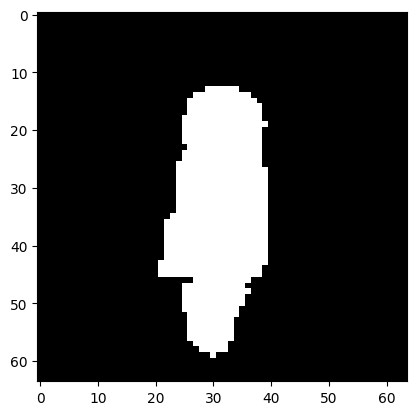

In [7]:
# 读取掩码图并转换为 RGB，再调整到指定大小
mask_image = (
    Image.open(mask_path)       # 打开本地掩码图片
    .convert("RGB")             # 转换为 RGB 模式
    .resize((img_height, img_width))  # 调整到 512×512
)

# 调整掩膜图像大小到 64×64
mask_image_latent_size = mask_image.resize((64,64))

# 将图像转换为 NumPy 数组，取第一个通道，阈值化后转换为浮点型张量
mask_image_latent_size = torch.tensor(
    (np.array(mask_image_latent_size)[..., 0] > 5).astype(np.float32)
)

# 可视化二值化后的掩膜图像
plt.imshow(mask_image_latent_size.numpy(), cmap='gray')

# 将张量移动到指定设备（如 GPU）
mask_image_latent_size = mask_image_latent_size.to(device)

# 查看张量的形状
mask_image_latent_size.shape


d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


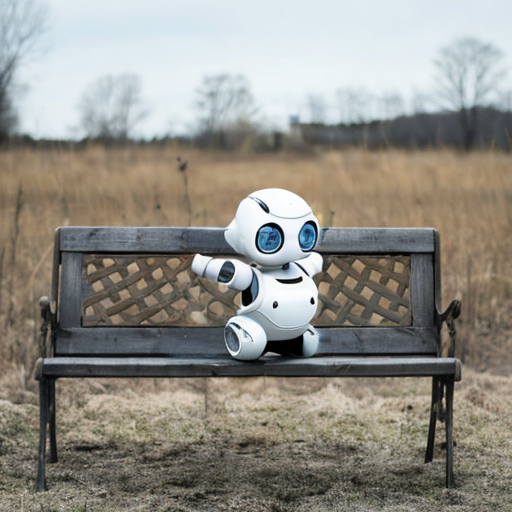

In [11]:
guidance_scale = 8 
num_inference_steps = 30
prompt = "A small robot, high resolution, sitting on a park bench"
negative_prompt = "zoomed in, blurry, oversaturated, warped"
generator = torch.Generator(device=device).manual_seed(42)

# 编码提示语
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# 创建随机起始点
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# 准备调度器
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

for i, t in enumerate(pipe.scheduler.timesteps):
    # 如果执行无分类器引导，则扩展潜变量
    latent_model_input = torch.cat([latents] * 2)
    
    # 应用调度器所需的缩放
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # 使用 UNet 预测噪声残差
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # 执行引导
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 计算前一步的噪声样本 x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    # 执行修复以填充掩码区域
    if i < len(pipe.scheduler.timesteps)-1:
        # 在前一步 t-1 的原始图像潜变量上添加噪声
        noise = torch.randn(init_image_latents.shape, generator=generator, device=device, dtype=torch.float32)
        background = pipe.scheduler.add_noise(init_image_latents, noise, torch.tensor([pipe.scheduler.timesteps[i+1]])) 

        latents = latents * mask_image_latent_size  # 掩码区域保留生成结果
        background = background * (1-mask_image_latent_size)  # 其他区域保留原图潜变量

        # 根据掩码组合生成和原始图像的潜变量
        latents += background

# 解码潜变量
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    inpainted_image = pipe.vae.decode(latents_norm).sample

inpainted_image = (inpainted_image / 2 + 0.5).clamp(0, 1).squeeze()
inpainted_image = (inpainted_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
inpainted_image = Image.fromarray(inpainted_image)

inpainted_image


![depth to image examples](https://camo.githubusercontent.com/50c14634d9ff835abd36693cccbdb12fc153e56226414186012641ab75b70b6f/68747470733a2f2f68756767696e67666163652e636f2f73746162696c69747961692f737461626c652d646966667573696f6e2d322d64657074682f7265736f6c76652f6d61696e2f646570746832696d6167652e706e67)
_Input image, depth image and generated examples (image source: StabilityAI)_

Img2Img 很强大，但有时我们想在保留原始构图的同时，替换掉颜色或纹理。要找到既能保持布局，又不会保留输入色彩的 Img2Img strength 值并不容易。

这就轮到另一个微调模型登场了！该模型在生成时额外引入深度信息作为条件。pipeline 会先使用深度估计模型生成深度图，然后将该深度图输入微调后的 UNet，以期在填充全新内容的同时，尽可能保留初始图像的深度和结构。


In [ ]:

pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)


prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result');

请注意将输出与 **img2img** 示例进行对比——此处的色彩变化更为丰富，但整体结构仍忠实于原图。尽管在这个例子中，为了符合狗的轮廓，男子被赋予了异常诡异的身体结构，因此效果并不理想，但在某些场景中这种方法却极为实用。想看看这种做法的「杀手级应用」吗？可以点开这条 [tweet](https://twitter.com/CarsonKatri/status/1600248599254007810?s=20&t=BlzSK26sfqi2336SN0gKpQ)，里面演示了如何利用 **depth** 模型为 3D 场景生成贴图！
